In [3]:
%matplotlib notebook

In [25]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from skimage.feature import canny
from skimage.draw import circle
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')

        
def display_labels_on_image(image,label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(image,cmap=plt.cm.gray)
    edges = np.nonzero(canny(label_image.astype(np.float)))
    ax.plot(edges[1],edges[0],'.b',markersize=3)
    ax.axis('image')
    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

def read_noise_covariance_matrix(filename):
    f = open(filename,'rb')
    xml_length = np.fromfile(f,dtype=np.uint32,count=1)
    xml_header = f.read(xml_length)
    noise_dwell_time = np.fromfile(f,dtype=np.float32,count=1)
    cov_length = np.fromfile(f,dtype=np.uint64,count=1)
    ndim = np.fromfile(f,dtype=np.uint64,count=1)
    dims = np.fromfile(f,dtype=np.uint64,count=ndim)
    cov_mtx = np.fromfile(f,dtype=np.complex64,count=np.prod(dims))
    cov_mtx = cov_mtx.reshape(dims)
    f.close()
    return cov_mtx

In [36]:
import csv
import re
f = open('/home/hansenms/data/PANDA/NIH_PANDA/DAY6_SPIRAL_SNR/DAT/filelist.csv', 'rt')
reader = csv.reader(f)
ssfp_spiral_scans = dict()
cart_scans = dict()
for row in reader:
    fname = row[0]
    scan_name = re.search('FID[0-9]{5}_([^.]+).dat',fname).group(1)
    scan_info = {'TR':float(row[1]), 'lines': int(row[2]), 'dwell_time': float(row[3]), 'samples': int(row[4])}
    scan_info['frame_time'] = scan_info['TR']*scan_info['lines']
    scan_info['sampling_time'] = scan_info['samples']*scan_info['dwell_time']/1000*scan_info['lines']
    scan_info['sampling_duty_cycle'] = scan_info['sampling_time']/scan_info['frame_time']
    if re.search('CART',scan_name):
        cart_scans[scan_name] = scan_info
    elif re.search('SPIR',scan_name):
        ssfp_spiral_scans[scan_name] = scan_info        
f.close()

In [37]:
cart_scans

{'CART_BW1002_TR0268': {'TR': 2.68,
  'dwell_time': 3.9,
  'frame_time': 343.04,
  'lines': 128,
  'samples': 256,
  'sampling_duty_cycle': 0.3725373134328358,
  'sampling_time': 127.7952}}

In [38]:
ssfp_spiral_scans

{'SPIR_BW150_TR4341_I8': {'TR': 43.41,
  'dwell_time': 26.0,
  'frame_time': 347.28,
  'lines': 8,
  'samples': 1610,
  'sampling_duty_cycle': 0.9642939414881364,
  'sampling_time': 334.88},
 'SPIR_BW160_TR2166_I16': {'TR': 21.66,
  'dwell_time': 24.4,
  'frame_time': 346.56,
  'lines': 16,
  'samples': 808,
  'sampling_duty_cycle': 0.9102123730378576,
  'sampling_time': 315.44319999999993},
 'SPIR_BW180_TR1084_I32': {'TR': 10.84,
  'dwell_time': 21.7,
  'frame_time': 346.88,
  'lines': 32,
  'samples': 410,
  'sampling_duty_cycle': 0.8207564575645757,
  'sampling_time': 284.704},
 'SPIR_BW210_TR0713_I48': {'TR': 7.13,
  'dwell_time': 18.6,
  'frame_time': 342.24,
  'lines': 48,
  'samples': 280,
  'sampling_duty_cycle': 0.7304347826086957,
  'sampling_time': 249.984},
 'SPIR_BW250_TR0529_I64': {'TR': 5.29,
  'dwell_time': 15.6,
  'frame_time': 338.56,
  'lines': 64,
  'samples': 216,
  'sampling_duty_cycle': 0.6369754253308128,
  'sampling_time': 215.65439999999998},
 'SPIR_BW360_TR03

In [21]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_PANDA/DAY6_SPIRAL_SNR/DICOM')
print_dicom_summary(d)

15	1	CART_BW1002_TR0268__GT
16	1	CART_BW1002_TR0268__GT_SNR_MAP
17	1	CART_BW1002_TR0268__GT_Noise_SD_Plot
30	50	SPIR_BW360_TR0360_I96__GT
31	1	SPIR_BW360_TR0360_I96__GT_SNR_MAP
32	50	SPIR_BW250_TR0529_I64__GT
33	1	SPIR_BW250_TR0529_I64__GT_SNR_MAP
34	50	SPIR_BW210_TR0713_I48__GT
35	1	SPIR_BW210_TR0713_I48__GT_SNR_MAP
36	50	SPIR_BW180_TR1084_I32__GT
37	1	SPIR_BW180_TR1084_I32__GT_SNR_MAP
38	50	SPIR_BW160_TR2166_I16__GT
39	1	SPIR_BW160_TR2166_I16__GT_SNR_MAP
40	50	SPIR_BW150_TR4341_I8__GT
41	1	SPIR_BW150_TR4341_I8__GT_SNR_MAP
42	51	SPIR_BW500_TR1459_I8__GT
43	1	SPIR_BW500_TR1459_I8__GT_SNR_MAP


In [22]:
snr_images = [16,31,33,35,37,39,41,43]

In [39]:
for sname in ssfp_spiral_scans:
    for series in d:
        r = re.search('([A-Z0-9_]+)__GT_SNR_MAP',d[series][0].SeriesDescription)
        if r and r.group(1) == sname:
            ssfp_spiral_scans[sname]['dicom_series'] = series 
            break
            
for sname in cart_scans:
    for series in d:
        r = re.search('([A-Z0-9_]+)__GT_SNR_MAP',d[series][0].SeriesDescription)
        if r and r.group(1) == sname:
            cart_scans[sname]['dicom_series'] = series 
            break

In [43]:
ssfp_spiral_snr_images = sorted([ssfp_spiral_scans[k]['dicom_series'] for k in ssfp_spiral_scans])
cart_snr_images = sorted([cart_scans[k]['dicom_series'] for k in cart_scans])

<IPython.core.display.Javascript object>


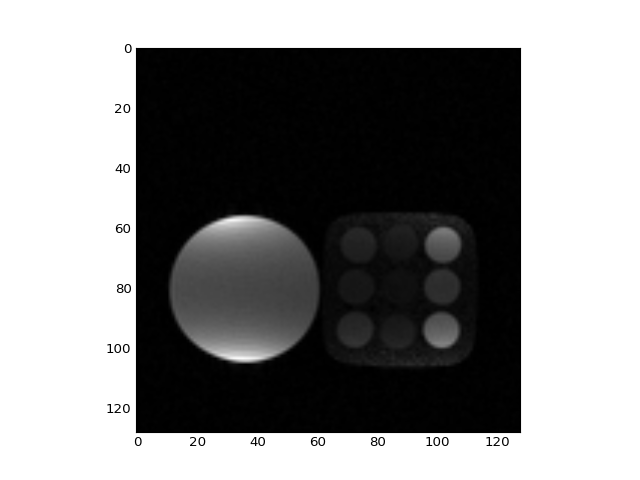

In [72]:
f, ax = plt.subplots(1,1)
img1 = ax.imshow(d[cart_snr_images[-1]][0].pixel_array,cmap=plt.cm.gray)

In [28]:
coords = []

def onclick(event):
    coords.append((event.xdata, event.ydata))

    if event.button == 3:
        f.canvas.mpl_disconnect(cid)

cid = f.canvas.mpl_connect('button_press_event', onclick)


In [30]:
coords

[(37.968750000000007, 78.927083333333343),
 (75.302083333333343, 64.927083333333343),
 (89.635416666666686, 64.59375),
 (102.96875, 64.927083333333343),
 (74.96875, 78.59375),
 (88.394946808510625, 78.453457446808528),
 (102.86303191489358, 78.027925531914917),
 (74.139627659574458, 92.708776595744695),
 (88.182180851063805, 93.347074468085111),
 (103.50132978723403, 93.134308510638306)]

In [31]:
stored_coords = [(37.968750000000007, 78.927083333333343),
 (75.302083333333343, 64.927083333333343),
 (89.635416666666686, 64.59375),
 (102.96875, 64.927083333333343),
 (74.96875, 78.59375),
 (88.394946808510625, 78.453457446808528),
 (102.86303191489358, 78.027925531914917),
 (74.139627659574458, 92.708776595744695),
 (88.182180851063805, 93.347074468085111),
 (103.50132978723403, 93.134308510638306)]

In [32]:
coords = stored_coords

In [33]:
radius = 3
labels = np.zeros(d[42][0].pixel_array.shape,dtype=np.int)
for idx,c in enumerate(coords):
    cc,rr = circle(c[1],c[0],radius)
    labels[cc,rr] = idx+1


<IPython.core.display.Javascript object>


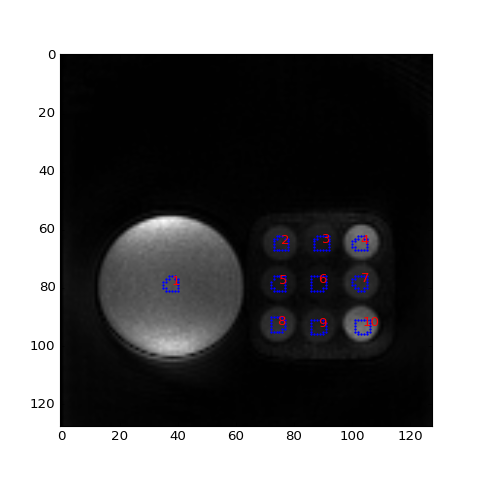

In [45]:
display_labels_on_image(d[ssfp_spiral_snr_images[0]][0].pixel_array,labels)

In [48]:
for m in ssfp_spiral_scans:
    im_pixels = d[ssfp_spiral_scans[m]['dicom_series']][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    ssfp_spiral_scans[m]['snr'] = mean_vals

for m in cart_scans:
    im_pixels = d[cart_scans[m]['dicom_series']][0].pixel_array
    mean_vals = get_label_mean(im_pixels,labels)
    cart_scans[m]['snr'] = mean_vals

<IPython.core.display.Javascript object>


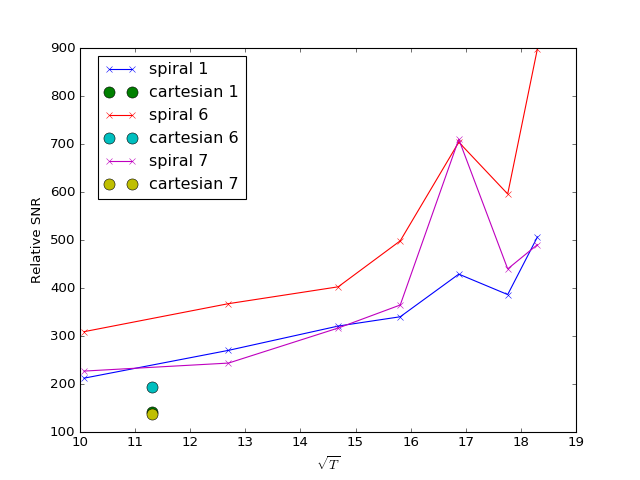

In [80]:
scans = ssfp_spiral_scans
f,ax = plt.subplots(1,1)

samps = [0,5,6]

handles = list()
for r in samps:
    
    tmp = ssfp_spiral_scans
    t = [tmp[s]['sampling_time'] for s in tmp]
    snr = [tmp[s]['snr'][r] for s in tmp]
    order = [i[0] for i in sorted(enumerate(t), key=lambda x:x[1])]
    t = [t[i] for i in order]
    snr = [snr[i] for i in order]
    
    l = ax.plot(np.sqrt(t),snr,'x-',label="spiral %d"%(r+1))
    handles.append(l[0])
    
    tmp = cart_scans
    t = [tmp[s]['sampling_time'] for s in tmp]
    snr = [tmp[s]['snr'][r] for s in tmp]
    order = [i[0] for i in sorted(enumerate(t), key=lambda x:x[1])]
    t = [t[i] for i in order]
    snr = [snr[i] for i in order]
    
    l = ax.plot(np.sqrt(t),snr,'o',label="cartesian %d"%(r+1),markersize=10)
    handles.append(l[0])
    
    ax.set_xlabel('$\sqrt{T}$')
    ax.set_ylabel('Relative SNR')
ax.legend(bbox_to_anchor=(0.35, 1.00))

In [57]:
cart_scans

{'CART_BW1002_TR0268': {'TR': 2.68,
  'dicom_series': '16',
  'dwell_time': 3.9,
  'frame_time': 343.04,
  'lines': 128,
  'samples': 256,
  'sampling_duty_cycle': 0.3725373134328358,
  'sampling_time': 127.7952,
  'snr': [140.90815376016891,
   595.88888888888891,
   297.11111111111109,
   224.13333333333333,
   781.03703703703707,
   193.55555555555554,
   137.19999999999999,
   383.96296296296299,
   341.0,
   237.34482758620689,
   798.96428571428567]}}

In [77]:
sorted([ssfp_spiral_scans[k]['frame_time'] for k in ssfp_spiral_scans])

[116.72, 338.56, 342.24, 345.6, 346.56, 346.88, 347.28]

In [79]:
sorted([ssfp_spiral_scans[k]['sampling_time'] for k in ssfp_spiral_scans])

[101.46239999999999,
 161.1456,
 215.65439999999998,
 249.984,
 284.704,
 315.44319999999993,
 334.88]

In [83]:
from pandas import DataFrame
tmp = ssfp_spiral_scans
dat = {'T_acq': [tmp[s]['sampling_time'] for s in tmp],
     'int': [tmp[s]['lines'] for s in tmp],
     'TR': [tmp[s]['TR'] for s in tmp],
     'T_total': [tmp[s]['frame_time'] for s in tmp],
     'duty_cycle': [int(100*np.round(tmp[s]['sampling_duty_cycle'],2)) for s in tmp]}
df = DataFrame(data=dat)
df.sort_values('duty_cycle')

,TR,T_acq,T_total,duty_cycle,int
4,3.60,161.1456,345.60,47,96
6,5.29,215.6544,338.56,64,64
3,7.13,249.9840,342.24,73,48
5,10.84,284.7040,346.88,82,32
0,14.59,101.4624,116.72,87,8
1,21.66,315.4432,346.56,91,16
2,43.41,334.8800,347.28,96,8
